In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import data_generator
import ESPRIT
import QPE
import qcels 
import GFOS

In [2]:
def generate_ts_distribution(T,N,gamma):
    """ Generate time samples from truncated Gaussian
    Input:
    
    T : variance of Gaussian
    gamma : truncated parameter
    N : number of samples
    
    Output: 
    
    t_list: np.array of time points
    """
    t_list=truncnorm.rvs(-gamma, gamma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,population,T,N,gamma):
    """ Generate Z samples for a given T,N,gamma
    Input:
    
    spectrum: np.array of eigenvalues
    population: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    gamma : truncated parameter
    
    Output: 
    
    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,gamma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
    return Z_est, t_list, T_max, T_total

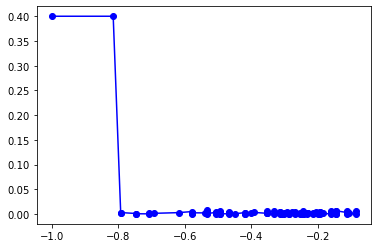

In [3]:
#Test TFIM
L = 8
J = 1.0
g = 4.0
p_list=np.array([0.4,0.4])
d=100

spectrum, population=data_generator.generate_initial_TFIM(L,J,g,p_list,d)

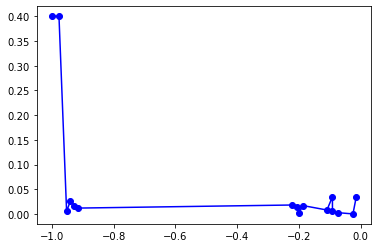

In [4]:
#Test Hubbard
L = 4
J = 1.0
U = 10.0
mu = 0.0
N_up = L // 2
N_down = L - N_up
p_list=np.array([0.4,0.4])
d=2**L

spectrum, population=data_generator.generate_initial_Hubbard(L,J,U,mu,N_up,N_down,p_list,d)

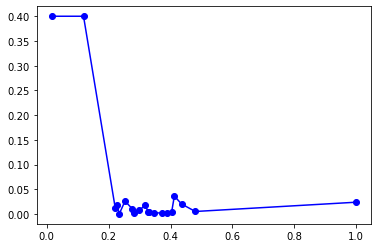

In [5]:
#Test random H
gap_list=np.array([0.1,0.1])
p_list=np.array([0.4,0.4])
d=20
spectrum, population=data_generator.generate_random_Hamiltonian(gap_list,p_list,d)

In [6]:
#Test generate_data
t_list=np.arange(10)+1
N_list=np.arange(10)+1
Z, T_max, T_total=data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
print(Z)
print(T_max)
print(T_total)
print(np.sum(np.multiply(t_list,N_list)))

[1.        +1.j         1.        -1.j         0.33333333-1.j
 0.5       +0.j         1.        +0.2j        0.66666667-0.33333333j
 0.71428571-0.71428571j 0.75      -0.25j       0.11111111-0.55555556j
 0.6       -0.2j       ]
10
385
385


# Test GFOS

In [7]:
T_list=np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200,1400,1600,1800,2000,2300,2600,2800,3000,4000])
N=3000
K=2
alpha=1
gamma=1
error_GFOS=np.zeros(len(T_list),dtype='float')
for k in range(len(T_list)):
    T_max=T_list[k]
    d_x=0.1/T_max
    Z_est,t_list, _, _ = generate_Z(spectrum,population,T_max,N,gamma)
    output_energy = GFOS.GFOS(Z_est, d_x, t_list, K, alpha, T_max)
    output_energy = np.sort(output_energy)
    ##---measure error--##
    index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
    dominant_energy=np.zeros(K,dtype=float)
    dominant_weight=np.zeros(K,dtype=float)
    for l in range(K):
            dominant_energy[l]=spectrum[index_list[l]]
            error_GFOS[k]=max(error_GFOS[k],min(np.abs(dominant_energy[l]-output_energy)))
    print('Tmax=',gamma*T_max)
    print('Output of GFOS energy=',output_energy)
    print('True dominant=',np.sort(dominant_energy))

G calculation start
G calculation finish
G calculation start
G calculation finish
G calculation start
G calculation finish
Tmax= 100
Output of GFOS energy= [0.01940735 0.11740735]
True dominant= [0.01626926 0.11881984]
G calculation start
G calculation finish
G calculation start
G calculation finish
G calculation start
G calculation finish
Tmax= 200
Output of GFOS energy= [0.01640735 0.11890735]
True dominant= [0.01626926 0.11881984]
G calculation start
G calculation finish
G calculation start
G calculation finish
G calculation start
G calculation finish
Tmax= 300
Output of GFOS energy= [0.01607401 0.11874068]
True dominant= [0.01626926 0.11881984]
G calculation start
G calculation finish
G calculation start
G calculation finish
G calculation start
G calculation finish
Tmax= 400
Output of GFOS energy= [0.01615735 0.11890735]
True dominant= [0.01626926 0.11881984]
G calculation start
G calculation finish
G calculation start
G calculation finish
G calculation start
G calculation finish
T

# Test QPE

In [8]:
# gap_list=np.array([0.1,0.1])
# p_list=np.array([0.4,0.4])
# d=20
# spectrum, population=data_generator.generate_random_Hamiltonian(gap_list,p_list,d)
# L = 8
# J = 1.0
# g = 4.0
# p_list=np.array([0.4,0.4])
# d=100
# spectrum, population=data_generator.generate_initial_TFIM(L,J,g,p_list,d)
N_QPE=30
error_QPE=np.zeros(len(T_list),dtype='float')
for k in range(len(T_list)):
    T_max=T_list[k]
    output_energy = QPE.QPE(spectrum,population,T_max,N_QPE)
    ##---measure error--##
    error_QPE[k]=np.abs(spectrum[0]-output_energy)
    print('Tmax=',T_max)
    print('Output of QPE energy=',output_energy)
    print('True ground=',spectrum[0])

Tmax= 100
Output of QPE energy= 0.0
True ground= 0.016269256888598125
Tmax= 200
Output of QPE energy= -0.1256637061435919
True ground= 0.016269256888598125
Tmax= 300
Output of QPE energy= 0.0
True ground= 0.016269256888598125
Tmax= 400
Output of QPE energy= 0.015707963267948877
True ground= 0.016269256888598125
Tmax= 500
Output of QPE energy= 0.012566370614359279
True ground= 0.016269256888598125
Tmax= 600
Output of QPE energy= 0.01047197551196577
True ground= 0.016269256888598125
Tmax= 700
Output of QPE energy= 0.008975979010256374
True ground= 0.016269256888598125
Tmax= 800
Output of QPE energy= 0.015707963267948877
True ground= 0.016269256888598125
Tmax= 900
Output of QPE energy= 0.013962634015954656
True ground= 0.016269256888598125
Tmax= 1000
Output of QPE energy= 0.0062831853071796395
True ground= 0.016269256888598125
Tmax= 1100
Output of QPE energy= 0.01713595992867134
True ground= 0.016269256888598125
Tmax= 1200
Output of QPE energy= 0.015707963267948877
True ground= 0.01626925

# Test ESPRIT

In [9]:
# gap_list=np.array([0.1,0.1])
# p_list=np.array([0.4,0.4])
# d=20
# spectrum, population=data_generator.generate_random_Hamiltonian(gap_list,p_list,d)
t_list=np.arange(max(T_list))
N_list=np.ones(len(t_list))
f_values,_,_=data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
K_ESPRIT=2
K_dominant=2
nt_array=T_list
error_ESPRIT=np.zeros(len(nt_array),dtype='float')
for k in range(len(nt_array)):
    dt=1
    nt_effective=nt_array[k]
    #ESPRIT
    output_energy = ESPRIT.ESPRIT(f_values[:nt_effective], int(nt_effective/2), nt_effective, K_ESPRIT)
    ##---measure error--##
    index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
    dominant_energy=np.zeros(K_dominant,dtype=float)
    dominant_weight=np.zeros(K_dominant,dtype=float)
    for l in range(K_dominant):
            dominant_energy[l]=spectrum[index_list[l]]
            error_ESPRIT[k]=max(error_ESPRIT[k],min(np.abs(dominant_energy[l]-output_energy)))
    print('Tmax=',nt_effective*dt)
    print('Output of ESPRIT energy=',output_energy)
    print('True dominant=',np.sort(dominant_energy))

Tmax= 100
Output of ESPRIT energy= [-0.04726337  0.09981659]
True dominant= [0.01626926 0.11881984]
Tmax= 200
Output of ESPRIT energy= [-0.03343017  0.11788466]
True dominant= [0.01626926 0.11881984]
Tmax= 300
Output of ESPRIT energy= [0.01900617 0.12054791]
True dominant= [0.01626926 0.11881984]
Tmax= 400
Output of ESPRIT energy= [0.01621742 0.11994123]
True dominant= [0.01626926 0.11881984]
Tmax= 500
Output of ESPRIT energy= [0.01747937 0.11983212]
True dominant= [0.01626926 0.11881984]
Tmax= 600
Output of ESPRIT energy= [0.01789213 0.11959747]
True dominant= [0.01626926 0.11881984]
Tmax= 700
Output of ESPRIT energy= [0.01793338 0.11955004]
True dominant= [0.01626926 0.11881984]
Tmax= 800
Output of ESPRIT energy= [0.01790904 0.11909473]
True dominant= [0.01626926 0.11881984]
Tmax= 900
Output of ESPRIT energy= [0.01716454 0.11881544]
True dominant= [0.01626926 0.11881984]
Tmax= 1000
Output of ESPRIT energy= [0.01675138 0.11867158]
True dominant= [0.01626926 0.11881984]
Tmax= 1100
Outp

# Test QCELS

In [10]:
error_QCELS=np.zeros(len(T_list),dtype='float')
N_0 = 3000 #N_0
N = 2000 #N
gamma=1
K_QCELS=2
for k in range(len(T_list)):
    T = T_list[k]
    T_0 = 10/(spectrum[1]-spectrum[0])
    dominant_energy_estimate=np.zeros(K_QCELS)
    Output_QCELS, _, _ = \
            qcels.qcels_multimodal(spectrum, population, T_0, T, N_0, N, gamma, K_QCELS, spectrum[0:2])#QCELS with time T
    output_energy=np.sort(Output_QCELS)
    ##---measure error--##
    index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
    dominant_energy=np.zeros(K_dominant,dtype=float)
    dominant_weight=np.zeros(K_dominant,dtype=float)
    for l in range(K_dominant):
            dominant_energy[l]=spectrum[index_list[l]]
            error_QCELS[k]=max(error_QCELS[k],min(np.abs(dominant_energy[l]-output_energy)))
    print('Tmax=',gamma*T)
    print('Output of QCELS energy=',output_energy)
    print('True dominant=',np.sort(dominant_energy))

Tmax= 100
Output of QCELS energy= [-0.00779689 -0.0044838   0.01706183  0.11953605  0.4045519   0.41332248]
True dominant= [0.01626926 0.11881984]
Tmax= 200
Output of QCELS energy= [-0.00773872  0.00656142  0.0161187   0.11934502  0.39719032  0.41913429]
True dominant= [0.01626926 0.11881984]
Tmax= 300
Output of QCELS energy= [0.0006509  0.01431385 0.01649424 0.11773343 0.38314006 0.39389473]
True dominant= [0.01626926 0.11881984]
Tmax= 400
Output of QCELS energy= [-0.01122402  0.01663306  0.03487402  0.11843106  0.40423736  0.44211009]
True dominant= [0.01626926 0.11881984]
Tmax= 500
Output of QCELS energy= [-3.48212406e-02 -1.19706225e-04  1.63602483e-02  1.18679030e-01
  3.82624056e-01  3.86748552e-01]
True dominant= [0.01626926 0.11881984]


/Users/zhiyan_ding/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Tmax= 600
Output of QCELS energy= [0.01645327 0.02036526 0.03555546 0.11845533 0.3643974  0.39537466]
True dominant= [0.01626926 0.11881984]
Tmax= 700
Output of QCELS energy= [-2.06504328e-02 -1.16882890e-04  1.65960909e-02  1.18673061e-01
  3.74788878e-01  4.21607326e-01]
True dominant= [0.01626926 0.11881984]
Tmax= 800
Output of QCELS energy= [-0.01800772  0.01394582  0.01640444  0.11891992  0.39644072  0.41607854]
True dominant= [0.01626926 0.11881984]
Tmax= 900
Output of QCELS energy= [-0.05299483 -0.03338027  0.01617165  0.11867213  0.38822505  0.39955524]
True dominant= [0.01626926 0.11881984]
Tmax= 1000
Output of QCELS energy= [0.00279489 0.01429259 0.0161718  0.1187524  0.39500599 0.39582357]
True dominant= [0.01626926 0.11881984]
Tmax= 1100
Output of QCELS energy= [-0.03420026  0.00644445  0.01628256  0.11861524  0.37300897  0.39593823]
True dominant= [0.01626926 0.11881984]
Tmax= 1200
Output of QCELS energy= [-0.0219744   0.01627636  0.01971993  0.11886921  0.39851432  0.4174

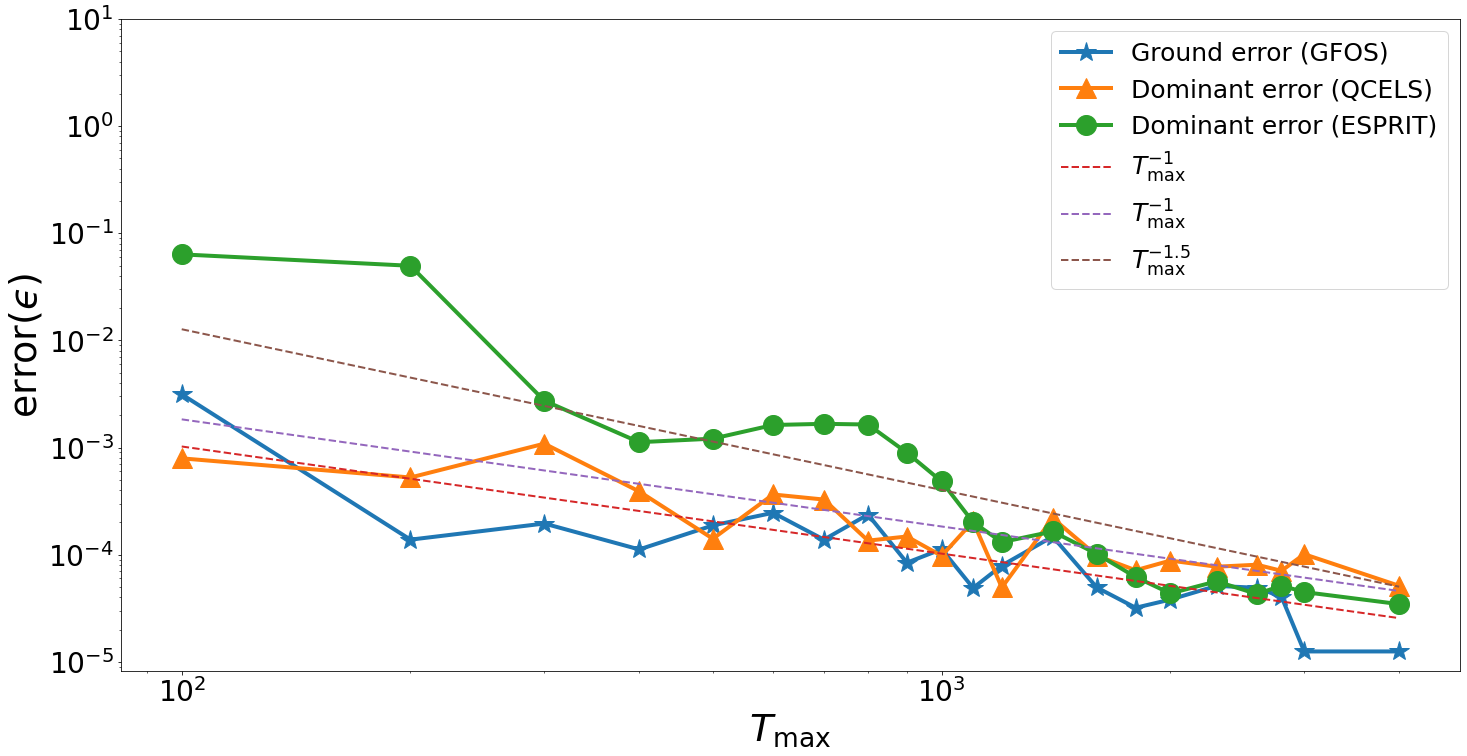

In [12]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 12))
plt.loglog(T_list, error_GFOS, marker="*",markersize=20,
           linewidth=4, label='Ground error (GFOS)')
# plt.loglog(T_list, error_QPE, marker="v",markersize=20,
#            linewidth=4, label='Ground error (QPE)')
plt.loglog(T_list, error_QCELS, marker="^",markersize=20,
           linewidth=4, label='Dominant error (QCELS)')
plt.loglog(T_list, error_ESPRIT, marker="o",markersize=20,
           linewidth=4, label='Dominant error (ESPRIT)')
plt.loglog(T_list, np.dot(error_GFOS[5:],T_list[5:])/T_list/len(error_GFOS[5:]), 
           '--', linewidth=2, label=r'$T_{\max}^{-1}$')
# plt.loglog(T_list, np.dot(error_QPE[5:],T_list[5:])/T_list/len(error_QPE[5:]), 
#            '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_QCELS[5:],T_list[5:])/T_list/len(error_QCELS[5:]),
           '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_ESPRIT[5:],T_list[5:]**1.5)/T_list**1.5/len(error_ESPRIT[5:]), 
           '--', linewidth=2, label=r'$T_{\max}^{-1.5}$')
plt.xlabel("$T_{\max}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)